In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import bisect
import collections
import sys
from sklearn.preprocessing import LabelEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
from sklearn.model_selection import train_test_split
from sklearn import tree
import graphviz
import scipy.stats as ss
import json
sys.path.append('/Users/pinecone/Git/TakeHomePractice')
import func
from numpy import nan

pd.set_option('max_columns',1000)
pd.set_option('max_row',300)

/Users/pinecone/anaconda3/lib/python3.7/site-packages/lightgbm/__init__.py:46: UserWarning: Starting from version 2.2.1, the library file in distribution wheels for macOS is built by the Apple Clang (Xcode_8.3.3) compiler.
This means that in case of installing LightGBM from PyPI via the ``pip install lightgbm`` command, you don't need to install the gcc compiler anymore.
Instead of that, you need to install the OpenMP library, which is required for running LightGBM on the system with the Apple Clang compiler.
You can install the OpenMP library by the following command: ``brew install libomp``.
  "You can install the OpenMP library by the following command: ``brew install libomp``.", UserWarning)


In [2]:
df = pd.read_csv('df.csv')
df_orig = pd.read_csv('df_orig.csv')

In [3]:
df.head()

,GoodForMeal,BusinessAcceptsCreditCards,Caters,BikeParking,WiFi,NoiseLevel,Ambience,HasTV,Alcohol,BusinessParking,OutdoorSeating,RestaurantsTakeOut,RestaurantsAttire,RestaurantsDelivery,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsGoodForGroups,business_id,stars
0,"{'dessert': False, 'latenight': False, 'lunch'...",True,False,True,'free',average,"{'romantic': False, 'intimate': False, 'classy...",True,full_bar,"{'garage': False, 'street': False, 'validated'...",False,True,'casual',False,True,False,2,True,BvYU3jvGd0TJ7IyZdfiN2Q,3.5
1,"{'dessert': False, 'latenight': False, 'lunch'...",True,False,False,'free',quite,"{'romantic': False, 'intimate': False, 'classy...",True,full_bar,"{'garage': False, 'street': False, 'validated'...",False,True,'casual',False,True,True,3,True,jtlAfuINMCYVFpjwMgy2jw,4.0
2,"{'dessert': False, 'latenight': False, 'lunch'...",True,False,False,'no',quite,"{'romantic': False, 'intimate': False, 'touris...",False,full_bar,"{'garage': True, 'street': False, 'validated':...",False,False,'dressy',False,True,False,3,True,wdsGP5rJinx0J5GcGzPQUw,4.0
3,"{'dessert': False, 'latenight': False, 'lunch'...",True,False,False,'free',quite,"{'romantic': False, 'intimate': False, 'touris...",False,full_bar,"{'garage': False, 'street': False, 'validated'...",True,True,'dressy',False,True,True,3,True,SZ5KO1KNiwtrktKo5mpuLA,3.5
4,"{'dessert': False, 'latenight': False, 'lunch'...",True,True,False,'no',very_loud,"{'romantic': False, 'intimate': False, 'classy...",False,full_bar,"{'garage': False, 'street': True, 'validated':...",True,True,'casual',False,True,True,3,True,dGnjfY3KyeLg-nBQaT3Xqw,4.5


In [4]:
goodformeal = []
for elem in df.GoodForMeal:
    if not elem:
        goodformeal.append(np.nan)
    else:
        goodformeal.append(eval(str(elem)))

buspart = []
for elem in df.BusinessParking:
    if not elem:
        buspart.append(np.nan)
    else:
        buspart.append(eval(str(elem)))


amb = []
for elem in df.Ambience:
    if not elem:
        amb.append(np.nan)
    else:
        amb.append(eval(str(elem)))

In [5]:
df['BusinessParking'] = buspart
df['Ambience'] = amb
df['GoodForMeal'] = goodformeal

In [6]:
GoodForMeal = df['GoodForMeal'].apply(pd.Series)
BusinessParking = df['BusinessParking'].apply(pd.Series)
Ambience = df['Ambience'].apply(pd.Series)

In [7]:
del df['BusinessParking']
del df['Ambience']
del df['GoodForMeal']

df = pd.concat((df, GoodForMeal, BusinessParking, Ambience), axis=1)

In [8]:
df.head()

,BusinessAcceptsCreditCards,Caters,BikeParking,WiFi,NoiseLevel,HasTV,Alcohol,OutdoorSeating,RestaurantsTakeOut,RestaurantsAttire,RestaurantsDelivery,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsGoodForGroups,business_id,stars,dessert,latenight,lunch,dinner,brunch,breakfast,garage,street,validated,lot,valet,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual
0,True,False,True,'free',average,True,full_bar,False,True,'casual',False,True,False,2,True,BvYU3jvGd0TJ7IyZdfiN2Q,3.5,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
1,True,False,False,'free',quite,True,full_bar,False,True,'casual',False,True,True,3,True,jtlAfuINMCYVFpjwMgy2jw,4.0,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,True,False,False,'no',quite,False,full_bar,False,False,'dressy',False,True,False,3,True,wdsGP5rJinx0J5GcGzPQUw,4.0,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False
3,True,False,False,'free',quite,False,full_bar,True,True,'dressy',False,True,True,3,True,SZ5KO1KNiwtrktKo5mpuLA,3.5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,True,False,'no',very_loud,False,full_bar,True,True,'casual',False,True,True,3,True,dGnjfY3KyeLg-nBQaT3Xqw,4.5,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [9]:
func.missing_data(df)

,BusinessAcceptsCreditCards,Caters,BikeParking,WiFi,NoiseLevel,HasTV,Alcohol,OutdoorSeating,RestaurantsTakeOut,RestaurantsAttire,RestaurantsDelivery,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsGoodForGroups,business_id,stars,dessert,latenight,lunch,dinner,brunch,breakfast,garage,street,validated,lot,valet,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual
Total,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,7,200,1,1,4,1
Percent,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.0630915,0.0630915,0.0630915,0.44164,12.6183,0.0630915,0.0630915,0.252366,0.0630915
Types,bool,bool,bool,object,object,bool,object,bool,bool,object,bool,bool,bool,int64,bool,object,float64,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,bool,object,object,object,object,object,object,object,object,object


In [10]:
len(df)

1585

In [11]:
df['dinner'] = df['dinner'].fillna(value=True)
df['lot'] = df['lot'].fillna(value=True)
df['casual'] = df['casual'].fillna(value=True)


In [12]:
df = df.fillna(value=False)

In [13]:
df.head()

,BusinessAcceptsCreditCards,Caters,BikeParking,WiFi,NoiseLevel,HasTV,Alcohol,OutdoorSeating,RestaurantsTakeOut,RestaurantsAttire,RestaurantsDelivery,RestaurantsReservations,GoodForKids,RestaurantsPriceRange2,RestaurantsGoodForGroups,business_id,stars,dessert,latenight,lunch,dinner,brunch,breakfast,garage,street,validated,lot,valet,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual
0,True,False,True,'free',average,True,full_bar,False,True,'casual',False,True,False,2,True,BvYU3jvGd0TJ7IyZdfiN2Q,3.5,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,True
1,True,False,False,'free',quite,True,full_bar,False,True,'casual',False,True,True,3,True,jtlAfuINMCYVFpjwMgy2jw,4.0,False,False,False,True,False,False,False,False,False,True,False,False,False,False,False,False,False,False,False,False
2,True,False,False,'no',quite,False,full_bar,False,False,'dressy',False,True,False,3,True,wdsGP5rJinx0J5GcGzPQUw,4.0,False,False,False,True,False,False,True,False,False,False,True,False,False,True,False,False,False,False,False,False
3,True,False,False,'free',quite,False,full_bar,True,True,'dressy',False,True,True,3,True,SZ5KO1KNiwtrktKo5mpuLA,3.5,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False
4,True,True,False,'no',very_loud,False,full_bar,True,True,'casual',False,True,True,3,True,dGnjfY3KyeLg-nBQaT3Xqw,4.5,False,False,False,True,False,False,False,True,False,False,False,False,False,False,False,False,False,False,False,True


In [14]:
df.NoiseLevel.unique()

array(['average', 'quite', 'very_loud', 'loud'], dtype=object)

In [15]:
X = df.drop(['stars', 'business_id'], axis=1)

In [16]:
col_list = ['WiFi', 'Alcohol', 'RestaurantsAttire', 
           'RestaurantsPriceRange2', ]
X = func.LBOH_trans(X, col_list=col_list, trans='OH')

In [17]:
noisy = []
for elem in X.NoiseLevel:
    if elem == 'quite':
        noisy.append(0)
    elif elem == 'average':
        noisy.append(1)
    elif elem == 'loud':
        noisy.append(2)
    else:
        noisy.append(3)
X['NoiseLevel'] = noisy

In [18]:
X = X.astype(int)
X.head()

,BusinessAcceptsCreditCards,Caters,BikeParking,NoiseLevel,HasTV,OutdoorSeating,RestaurantsTakeOut,RestaurantsDelivery,RestaurantsReservations,GoodForKids,RestaurantsGoodForGroups,dessert,latenight,lunch,dinner,brunch,breakfast,garage,street,validated,lot,valet,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual,WiFi_'free',WiFi_'no',WiFi_'paid',Alcohol_beer_and_wine,Alcohol_full_bar,RestaurantsAttire_'casual',RestaurantsAttire_'dressy',RestaurantsPriceRange2_1,RestaurantsPriceRange2_2,RestaurantsPriceRange2_3,RestaurantsPriceRange2_4
0,1,0,1,1,1,0,1,0,1,0,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,1,0,0,0,1,1,0,0,1,0,0
1,1,0,0,0,1,0,1,0,1,1,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,0,1,0
2,1,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0
3,1,0,0,0,0,1,1,0,1,1,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,1,0
4,1,1,0,3,0,1,1,0,1,1,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,1,1,0,0,0,1,0


In [19]:
X.columns = ['BusinessAcceptsCreditCards', 'Caters', 'BikeParking', 'NoiseLevel',
       'HasTV', 'OutdoorSeating', 'RestaurantsTakeOut', 'RestaurantsDelivery',
       'RestaurantsReservations', 'GoodForKids', 'RestaurantsGoodForGroups',
       'dessert', 'latenight', 'lunch', 'dinner', 'brunch', 'breakfast',
       'garage', 'street', 'validated', 'lot', 'valet', 'romantic', 'intimate',
       'classy', 'hipster', 'divey', 'touristy', 'trendy', 'upscale', 'casual',
       'WiFi_free', 'WiFi_no', 'WiFi_pain', 'Alcohol_beer_and_wine',
       'Alcohol_full_bar', 'RestaurantsAttire_casual',
       'RestaurantsAttire_dressy', 'RestaurantsPriceRange2_1',
       'RestaurantsPriceRange2_2', 'RestaurantsPriceRange2_3',
       'RestaurantsPriceRange2_4']

In [20]:
import collections
y = df['stars']
collections.Counter(y)

Counter({3.5: 456,
         4.0: 426,
         4.5: 118,
         2.5: 184,
         3.0: 317,
         5.0: 15,
         2.0: 58,
         1.5: 11})

In [21]:
y = np.array(y)
for i in range(len(y)):
    if y[i] <= 3:
        y[i] = 1
    elif y[i] == 3.5:
        y[i] = 2
    else:
        y[i] = 3

In [22]:
collections.Counter(y)

Counter({2.0: 456, 3.0: 559, 1.0: 570})

In [23]:
lb = LabelEncoder()
y = lb.fit_transform(y)

In [24]:
dt = tree.DecisionTreeClassifier(max_depth=4, min_samples_leaf=80,min_samples_split=50, class_weight='balanced')
dt.fit(X,y)

DecisionTreeClassifier(class_weight='balanced', criterion='gini', max_depth=4,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=80, min_samples_split=50,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=None, splitter='best')

In [25]:
graph = func.plot_tree(dt, X.columns, ["A", "B", "C", "D"])

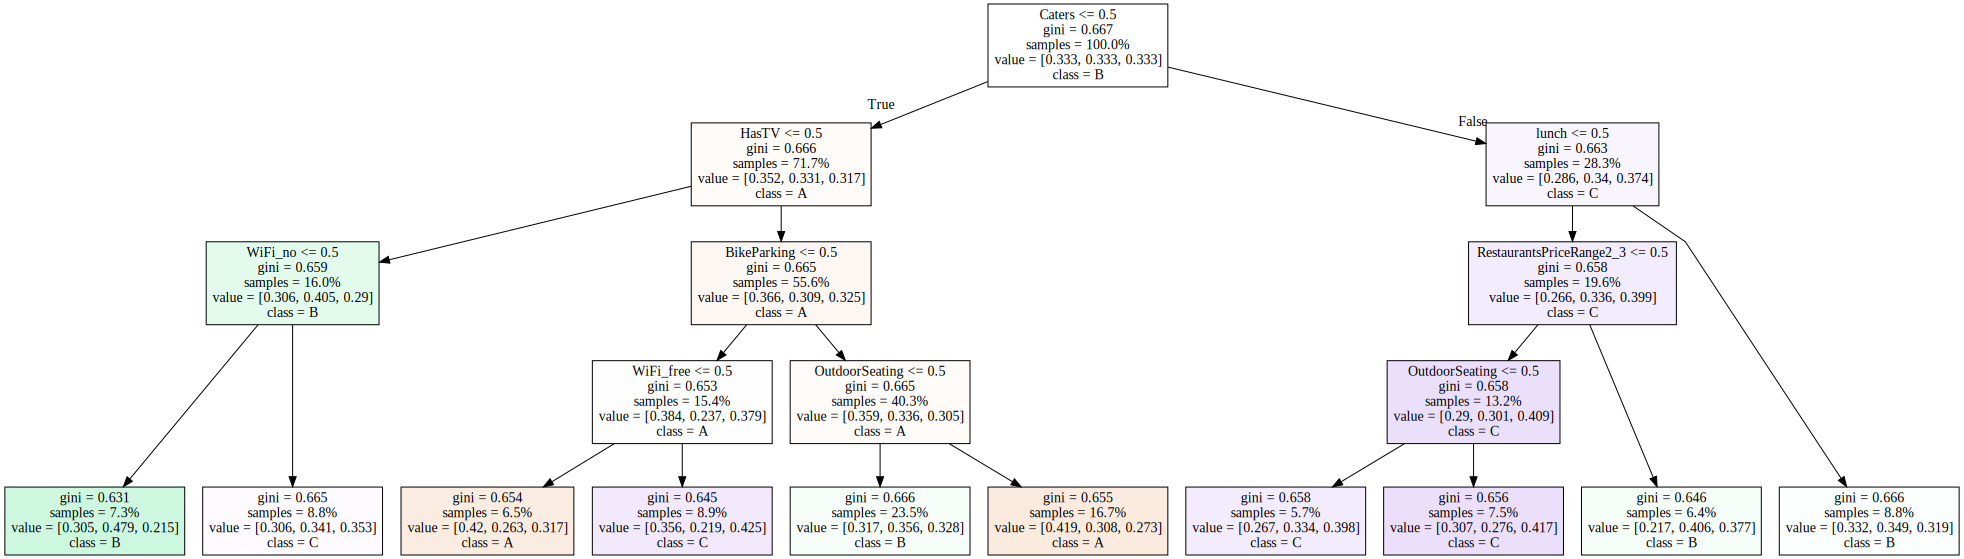

In [26]:
graph

In [33]:
print(classification_report(dt.predict(X), y))

              precision    recall  f1-score   support

           0       0.29      0.45      0.35       368
           1       0.53      0.33      0.41       728
           2       0.36      0.42      0.39       489

    accuracy                           0.39      1585
   macro avg       0.40      0.40      0.38      1585
weighted avg       0.42      0.39      0.39      1585



In [26]:
graph.render("tree") 

'tree.pdf'

In [27]:
imp = pd.DataFrame({"name": X.columns, "importance": dt.feature_importances_})

In [28]:
imp.sort_values(by='importance', ascending=False)

,name,importance
4,HasTV,0.135912
2,BikeParking,0.134370
1,Caters,0.119425
5,OutdoorSeating,0.118920
32,WiFi_no,0.118655
3,NoiseLevel,0.078254
40,RestaurantsPriceRange2_3,0.068274
39,RestaurantsPriceRange2_2,0.058900
20,lot,0.055496
31,WiFi_free,0.050657


In [29]:
GoodForMeal.head()
BusinessParking.head()
Ambience.head()

,romantic,intimate,classy,hipster,divey,touristy,trendy,upscale,casual
0,False,False,False,False,False,False,False,False,True
1,False,False,False,False,False,False,False,False,False
2,False,False,True,False,False,False,False,False,False
3,False,False,False,False,False,False,False,False,False
4,False,False,False,False,False,False,False,False,True


In [30]:
suggestions = pd.concat((pd.DataFrame(X[['Caters', 'trendy', 'HasTV', 'NoiseLevel', 'OutdoorSeating',
          'WiFi_no']]*1), df[['business_id', 'stars']]), axis=1)

In [31]:
suggestions.head()

,Caters,trendy,HasTV,NoiseLevel,OutdoorSeating,WiFi_no,business_id,stars
0,0,0,1,1,0,0,BvYU3jvGd0TJ7IyZdfiN2Q,3.5
1,0,0,1,0,0,0,jtlAfuINMCYVFpjwMgy2jw,4.0
2,0,0,0,0,0,1,wdsGP5rJinx0J5GcGzPQUw,4.0
3,0,0,0,0,1,0,SZ5KO1KNiwtrktKo5mpuLA,3.5
4,1,0,0,3,1,1,dGnjfY3KyeLg-nBQaT3Xqw,4.5


In [32]:
opinion = []
for i in range(len(suggestions)):
    sug = []
    if suggestions.Caters[i] == 0:
        sug.append('You should provide catering services.')
    if suggestions.trendy[i] == 1:
        sug.append('Customers prefer not to have trendy atmosphere, so you may need to change the ambience of your store.')
    if suggestions.HasTV[i] == 1:
        sug.append('The noise from TV may cause disturbance when custumers talk with each others.')
    if suggestions.NoiseLevel[i] == 1:
        sug.append('Please try to reduce the noisy! No one want to be interruptted when they are enjoying steaks.')
    if suggestions.OutdoorSeating[i] == 1:
        sug.append('Enjoying steaks is time-comsuming. If no more tables, not let customers wait outside, cause it will destroy their moods.')
    if suggestions.WiFi_no[i] == 1:
        sug.append('Please provide WIFI for custumers. So they don\'t feel boring when they are waiting in the line or waiting for meals.')
    opinion.append(sug)

In [33]:
temp = ['|'.join(x) for x in opinion]

In [34]:
temp

['You should provide catering services.|The noise from TV may cause disturbance when custumers talk with each others.|Please try to reduce the noisy! No one want to be interruptted when they are enjoying steaks.',
 'You should provide catering services.|The noise from TV may cause disturbance when custumers talk with each others.',
 "You should provide catering services.|Please provide WIFI for custumers. So they don't feel boring when they are waiting in the line or waiting for meals.",
 'You should provide catering services.|Enjoying steaks is time-comsuming. If no more tables, not let customers wait outside, cause it will destroy their moods.',
 "Enjoying steaks is time-comsuming. If no more tables, not let customers wait outside, cause it will destroy their moods.|Please provide WIFI for custumers. So they don't feel boring when they are waiting in the line or waiting for meals.",
 'The noise from TV may cause disturbance when custumers talk with each others.|Please try to reduce t

In [35]:
suggestions['suggestion'] = temp

In [36]:
suggestions.to_csv('/Users/pinecone/Desktop/WISC/628/Module3/yelp_review/suggestions2.csv', index=False)